In [8]:
# The dataset has 13 fields.

date - date of publication of the announcement;
time - the time when the ad was published;
geo_lat - Latitude
geo_lon - Longitude
region - Region of Russia. There are 85 subjects in the country in total.
building_type - Facade type. 0 - Other. 1 - Panel. 2 - Monolithic. 3 - Brick. 4 - Blocky. 5 - Wooden
object_type - Apartment type. 1 - Secondary real estate market; 2 - New building;
level - Apartment floor
levels - Number of storeys
rooms - the number of living rooms. If the value is "-1", then it means "studio apartment"
area - the total area of ​​the apartment square meters
kitchen_area - Kitchen area
price - Price. in rubles

from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
import pandas as pd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from matplotlib.dates import date2num 
from scipy import stats
import matplotlib.dates as dates
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier 
from pandas_profiling import ProfileReport
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
df = pd.read_csv('russian_homes.csv')

In [9]:
#Read in data, set the date as the index col, remove extreme outliers in the price column
def wrangle(filepath):
    df = pd.read_csv(filepath, parse_dates=['date'], index_col='date')
    df.drop(['time'],axis=1,inplace=True)
    df = df.drop_duplicates()
    
    return df

df = wrangle('russian_homes.csv')

overfivemil = df[df['price']>=365865000].index  
df.drop(overfivemil, inplace=True)

guh2 = df[df['price']<10000].index  
df.drop(guh2, inplace=True)


df.head()

price    geo_lat    geo_lon  region  building_type  level  \
date                                                                      
2018-02-19  6050000  59.805808  30.376141    2661              1      8   
2018-02-27  8650000  55.683807  37.297405      81              3      5   
2018-02-28  4000000  56.295250  44.061637    2871              1      5   
2018-03-01  1850000  44.996132  39.074783    2843              4     12   
2018-03-01  5450000  55.918767  37.984642      81              3     13   

            levels  rooms  area  kitchen_area  object_type  
date                                                        
2018-02-19      10      3  82.6          10.8            1  
2018-02-27      24      2  69.1          12.0            1  
2018-02-28       9      3  66.0          10.0            1  
2018-03-01      16      2  38.0           5.0           11  
2018-03-01      14      2  60.0          10.0            1

In [10]:
df.shape

(704495, 11)

In [11]:
#define y variable 
target = 'price'
y = df[target]
X = df.drop(columns=target)

In [12]:
#split data into train and test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
y_train.shape

(563596,)

In [14]:
y_val.shape

(140899,)

In [15]:
y_pred = [y_train.mean()] * len(y_train)

print("Mean Price", y_train.mean())
print('Baseline MAE: ', mean_absolute_error(y_train, y_pred))

Mean Price 4706082.335887764
Baseline MAE:  2930643.605295654


In [17]:
df.profile_report(correlations=None)

Summarize dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
#initial models 'not tuned'
model_lr = LinearRegression()

model_lr.fit(X_train, y_train)

LinearRegression()

In [13]:
#initial models 'not tuned'
model_r = Ridge()

model_r.fit(X_train, y_train)

Ridge()

In [14]:
#initial models 'not tuned'
model_rf = RandomForestRegressor(random_state=42, n_jobs=-1)

model_rf.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [15]:
#initial models 'not tuned'
model_xgb = XGBRegressor(random_state=42, n_jobs=-1)

model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [16]:
def check_metrics(model):
  print('Training MAE', mean_absolute_error(y_train, model.predict(X_train)))
  print('Validation MAE', mean_absolute_error(y_val, model.predict(X_val)))
  print('Validation R^2', model.score(X_val, y_val))
  print('Training R^2',model.score(X_train, y_train))
  print()


models = [model_lr, model_r, model_rf, model_xgb]

for m in models:
  check_metrics(m)

Training MAE 2216809.2932283613
Validation MAE 2230254.8633409515
Validation R^2 0.25506717037138116
Training R^2 0.28290193447465395

Training MAE 2216809.1527686976
Validation MAE 2230254.7234384166
Validation R^2 0.25506715132396884
Training R^2 0.28290193447463696

Training MAE 281865.60577084933
Validation MAE 740970.3994849023
Validation R^2 0.8484707667022928
Training R^2 0.9730870190927442

Training MAE 870218.3397752998
Validation MAE 930133.0262232388
Validation R^2 0.829148376397081
Training R^2 0.9005929100894006



In [17]:
#model tuning
clf_xgb = make_pipeline(
    
    SimpleImputer(),
    XGBRegressor(random_state=42, n_jobs=-1)
)



In [18]:
params={
    'xgbregressor__learning_rate'   : [0.03, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    'xgbregressor__max_depth'       : [3, 4, 5, 6, 7, 8, 10, 12, 15],
    'xgbregressor__min_child_weight': [1, 3, 5, 7, 8, 9, 10],
    'xgbregressor__gamma'           : [0.0, 0.1, 0.2, 0.3, 0.4],
    'xgbregressor__colsample_bytree': [0.3, 0.4, 0.5, 0.7, 0.08, 0.09],
    'xgbregressor__max_leaf_nodes'  : [3,5,6,7,9,10,12,15],
    'xgbregressor__n_estimators'    : [50,75,100,125,150,175,200]
}

In [19]:
model_RfRs = RandomizedSearchCV(
    clf_xgb, 
    param_distributions=params,
    n_iter=10,
    cv=5,
    n_jobs=-1,
    verbose=1
)

model_RfRs.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[22:02:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_leaf_nodes" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                             ('xgbregressor',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           gamma=None,
                                                           gpu_id=None,
                                                           importance_type='gain',
                                                           interaction_constraints=None,
                                                           learning_rate=None,
                                          

In [20]:
best_score = model_RfRs.best_score_
best_params = model_RfRs.best_params_

print('Best score for `model`:', best_score)
print()
print('Best params for `model`:', best_params)

Best score for `model`: 0.8282500615213838

Best params for `model`: {'xgbregressor__n_estimators': 175, 'xgbregressor__min_child_weight': 8, 'xgbregressor__max_leaf_nodes': 3, 'xgbregressor__max_depth': 15, 'xgbregressor__learning_rate': 0.2, 'xgbregressor__gamma': 0.0, 'xgbregressor__colsample_bytree': 0.7}


In [16]:
#model tuning
clf_rf = make_pipeline(
    SimpleImputer(),
    RandomForestRegressor(random_state=42, n_jobs=-1)
)


In [33]:
params={
    'randomforestregressor__n_estimators'     : [50,75,100,125,150,175,200],
    'randomforestregressor__max_depth'        : range(25, 40, 5),
    'randomforestregressor__min_samples_leaf' : range(25, 400, 25),
    'randomforestregressor__max_samples'      : [.1, .2, .3, .4, .5, .6, .7, .8, .9],
    'randomforestregressor__max_leaf_nodes'   : range(140, 170, 10),
    'randomforestregressor__max_features'     : range(0, 15, 1)
}

In [34]:
model_RfR = RandomizedSearchCV(
    clf_rf, 
    param_distributions=params,
    n_iter=10,
    cv=5,
    n_jobs=-1,
    verbose=1
)

model_RfR.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                             ('randomforestregressor',
                                              RandomForestRegressor(n_jobs=-1,
                                                                    random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'randomforestregressor__max_depth': range(25, 40, 5),
                                        'randomforestregressor__max_features': range(0, 15),
                                        'randomforestregressor__max_leaf_nodes': range(140, 170, 10),
                                        'randomforestregressor__max_samples': [0.1,
                                                                               0.2,
                                                                               0.3,
                                                                               0.4,


In [35]:
best_score = model_RfR.best_score_
best_params = model_RfR.best_params_

print('Best score for `model`:', best_score)
print()
print('Best params for `model`:', best_params)

Best score for `model`: 0.715423199124652

Best params for `model`: {'randomforestregressor__n_estimators': 125, 'randomforestregressor__min_samples_leaf': 125, 'randomforestregressor__max_samples': 0.9, 'randomforestregressor__max_leaf_nodes': 150, 'randomforestregressor__max_features': 8, 'randomforestregressor__max_depth': 35}


In [25]:
model_lr = LinearRegression()

model_lr.fit(X_train, y_train)

LinearRegression()

In [26]:
model_r = Ridge()

model_r.fit(X_train, y_train)

Ridge()

In [31]:
#Final model
model_rf = RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=125, min_samples_leaf=125, max_samples=0.9, max_leaf_nodes=150, max_features=8, max_depth=35)

model_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=35, max_features=7, max_leaf_nodes=150,
                      max_samples=0.8, min_samples_leaf=125, n_jobs=-1,
                      random_state=42)

In [27]:
#Final model
model_xgb = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=175, min_child_weight=8, max_leaf_nodes=3, max_depth=15, learning_rate=0.2, gamma=0.0, colsample_bytree=0.7)

model_xgb.fit(X_train, y_train)

[20:29:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_leaf_nodes" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=15,
             max_leaf_nodes=3, min_child_weight=8, missing=nan,
             monotone_constraints='()', n_estimators=175, n_jobs=-1,
             num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [32]:
def check_metrics(model):
  print('Training MAE', mean_absolute_error(y_train, model.predict(X_train)))
  print('Validation MAE', mean_absolute_error(y_val, model.predict(X_val)))
  print('Validation R^2', model.score(X_val, y_val))
  print()


models = [model_lr, model_r, model_rf, model_xgb]

for m in models:
  check_metrics(m)

Training MAE 2216809.2932283613
Validation MAE 2230254.8633409515
Validation R^2 0.25506717037138116

Training MAE 2216809.1527686976
Validation MAE 2230254.7234384166
Validation R^2 0.25506715132396884

Training MAE 1192480.5926923512
Validation MAE 1202798.7130832528
Validation R^2 0.7430080868405371

Training MAE 539652.9275674368
Validation MAE 768548.2915042702
Validation R^2 0.8587846059813049



In [41]:
perm_imp = permutation_importance(model_xgb, 
                                  X_val, 
                                  y_val, 
                                  n_repeats=5, 
                                  n_jobs=-1, 
                                  random_state=42)

<AxesSubplot:>

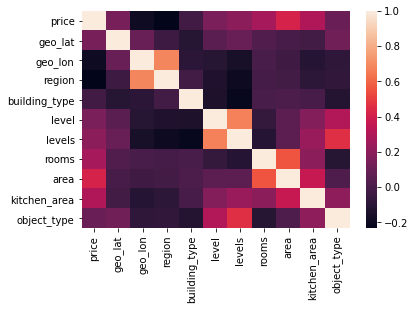

In [46]:
sns.heatmap(df.corr())

In [42]:
data = {'imp_mean': perm_imp['importances_mean'],
        'imp_std': perm_imp['importances_std']}

importances = pd.DataFrame(data, index=X_val.columns).sort_values(by='imp_mean')

importances.head()

imp_mean   imp_std
level          0.000868  0.000047
object_type    0.001097  0.000047
building_type  0.005211  0.000315
rooms          0.005678  0.000164
kitchen_area   0.009401  0.000248

<AxesSubplot:>

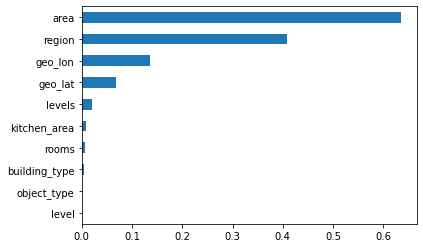

In [43]:
importances['imp_mean'].tail(10).plot(kind='barh')

<AxesSubplot:xlabel='geo_lat', ylabel='geo_lon'>

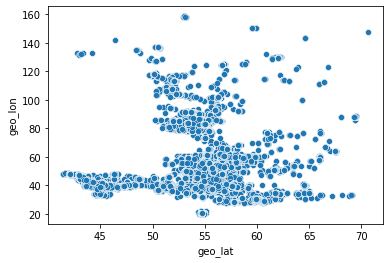

In [45]:
sns.scatterplot(x='geo_lat', y='geo_lon', data=df)